# IS53051A Machine Learning Assignment
### Jake Tyler (33683668) & Sonny Holland (33648903)

# Setting up our notebook


Importing libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk


Importing the dataset

In [5]:
dataset = pd.read_csv('datcw_na.csv')

# Data inspection and visualisation

First we take a brief look at our dataset.

In [6]:
print(dataset.head(), "\n")
print(dataset.info())

   X0    X1      X2      X3      X4    X5    X6   X7   X8      Y
0  C3  1.19  622.55     NaN   89.31  7.00  1.98  0.0  0.0  15.55
1  C1  1.19  622.55  323.40  109.15  7.70  3.00  0.0  0.0  15.55
2  C1  0.88  463.05  291.06   99.23  5.67  4.40  0.0  0.0  15.55
3  C2  0.79  509.36  291.06  121.28  6.30  4.05  0.0  0.0  15.55
4  C1  0.89  507.15  385.39  121.28  7.70  2.00  0.0  0.0  20.84 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X0      768 non-null    object 
 1   X1      768 non-null    float64
 2   X2      768 non-null    float64
 3   X3      728 non-null    float64
 4   X4      768 non-null    float64
 5   X5      768 non-null    float64
 6   X6      768 non-null    float64
 7   X7      768 non-null    float64
 8   X8      768 non-null    float64
 9   Y       768 non-null    float64
dtypes: float64(9), object(1)
memory usage: 60.1+ KB
None


### X3 has missing values and X0 is non-numerical

We can verify that column X3 contains 768 entries, where 40 values from those entries are missing.

We can also confirm that the column X0 is a categorical variable.

In [7]:
print(f"X3 number of entries: {dataset['X3'].size}")
print(f"X3 missing values: {dataset['X3'].isna().sum()}")
print(f"X0 contains: {dataset['X0'].unique()}")


X3 number of entries: 768
X3 missing values: 40
X0 contains: ['C3' 'C1' 'C2']


### Assessing options for handling categorical data and missing values in our dataset

When dealing with categorical data, we can either drop the column entirely or use one-hot encoding. One-hot encoding is the preferred method in our case later in this data analysis we can see this feature of the dataset does not have a neglegible correlation on the target variable. One-hot encoding allows us to make 3 new featrues from the categorical variable X0. These are all binary variables, where 1 represents the presence of the feature and 0 represents the absence of the feature.

For handling missing values, if the number of missing values is small and randomly distributed throughout the dataset we can consider replacing them with the mean, median, or mode of the non-missing values. Although, if the missing values are large in number or not randomly distributed it may be better to drop the the column altogether.

To better understand the missing values in our dataset, we can perform some basic types of analysis.

### Checking the percentage of missing data

We can check the percentage of missing values in our colums. Typically, if the percentage less than 5% we can consider this a small amount.

In [8]:
print(f"percentage of missing values per column:\n{dataset.isna().sum() / dataset.shape[0]}")

percentage of missing values per column:
X0    0.000000
X1    0.000000
X2    0.000000
X3    0.052083
X4    0.000000
X5    0.000000
X6    0.000000
X7    0.000000
X8    0.000000
Y     0.000000
dtype: float64


We can see the percentage of missing values is 0 amongst all but one feature. Whilst X3 (the outlying feature) does have 5% of its data missing, this is a small amount of missing data, one where imputation of the mean, mode, or median could infact be a viable option.

It's also important to note that the missing data (left alone) may still have an impact on the analysis. To continue, we can conduct a visual inspection to check the distribution and conclude whether it is random or non-random.

### Checking the distribution of values in X3

Using a histogram, we can visualise the distribution of non-missing values which will help us gain insights into the distribution of missing values.

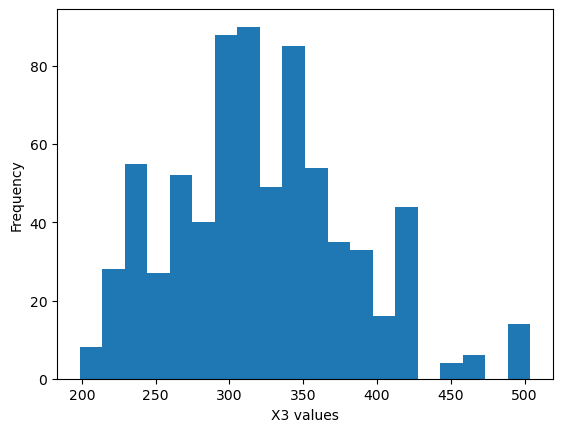

In [9]:
plt.hist(dataset['X3'], bins=20)
plt.xlabel('X3 values')
plt.ylabel('Frequency')
plt.show()

Since there is some uncertainty regarding this visualisation, we can investigate whether the distribution pattern is random or non-random by comparing it to some example histograms below:

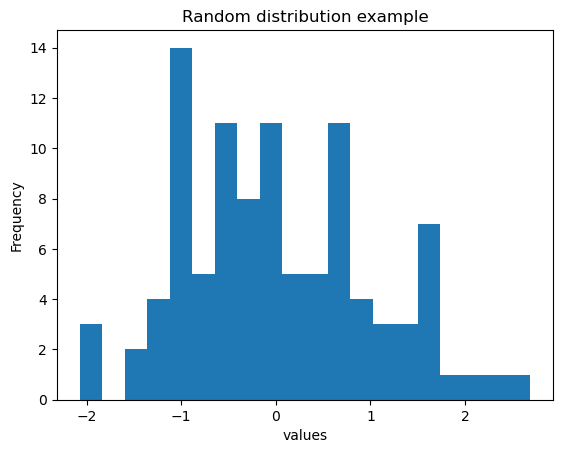

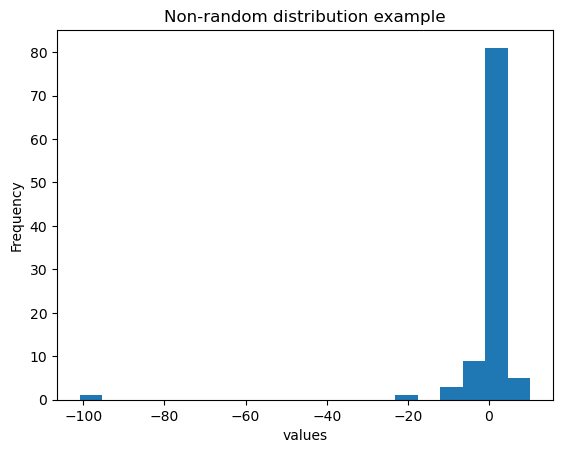

In [10]:
np.random.seed(48)

random_dataset = np.random.randn(100)
plt.title('Random distribution example')
plt.xlabel('values')
plt.ylabel('Frequency')
plt.hist(random_dataset, bins=20)
plt.show()

nonrandom_dataset = np.random.normal(0, 1, 100) ** 3
plt.title('Non-random distribution example')
plt.xlabel('values')
plt.ylabel('Frequency')
plt.hist(nonrandom_dataset, bins=20)
plt.show()


From this, we can conclude that the missing values in X3 follow typical random distribution patterns.

Since the percentage of missing values is also relatively small, we can consider replacing them with an appropriate imputation method such as the mean, mode or median.

Before deciding on an imputation method, it is important to analyse the relationship between X3 and the target variable. It is also important to test different imputation methods and examine their impact on the correlations with the target variable.

### Examining correlations between X3 and the target variable Y

array([[<Axes: xlabel='Y', ylabel='Y'>, <Axes: xlabel='X3', ylabel='Y'>],
       [<Axes: xlabel='Y', ylabel='X3'>,
        <Axes: xlabel='X3', ylabel='X3'>]], dtype=object)

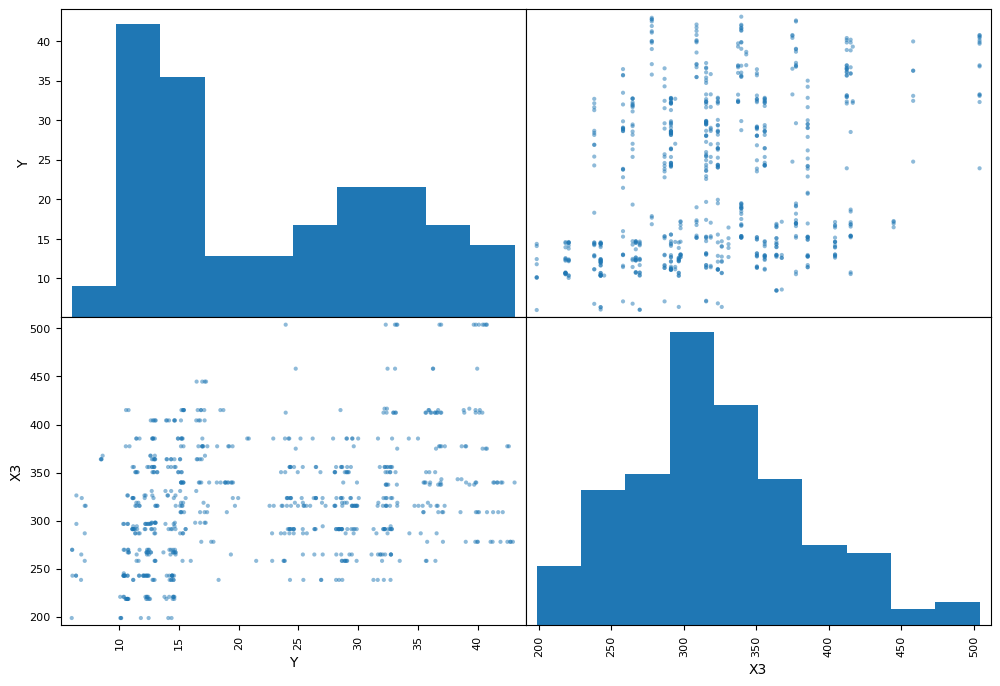

In [11]:
from pandas.plotting import scatter_matrix
attributes = ["Y", "X3"]
scatter_matrix(dataset[attributes], figsize=(12, 8))


From this visual inspection it would be reasonable to assume that there is a weak positive linear relationship between X3 and the target variable.

This means that as the value of X3 increases, the value of the target variable also tends to increase, but the relationship is not very strong or consistent.

### Testing different imputation methods and examining correlations

Here we calculate the correlations between X3 and Y with the mean, mode, and median imputations.

Its worth mentioning that there was a consideration to simulate missingness in our imputation methods. However, this is typically only needed when there is a large amount of missing data or if the missing data is not randomly distributed so the decision was made to leave this out.

In [12]:
corr_mean = dataset['X3'].fillna(dataset['X3'].mean()).corr(dataset['Y'])
corr_mode = dataset['X3'].fillna(dataset['X3'].mode()[0]).corr(dataset['Y'])
corr_median = dataset['X3'].fillna(dataset['X3'].median()).corr(dataset['Y'])

corr_dict = {
    'mean': corr_mean,
    'mode': corr_mode,
    'median': corr_median,
}

best_imputation = max(corr_dict, key=corr_dict.get)

print(f"Correlation between X3 and Y (mean imputation): {corr_mean}")
print(f"Correlation between X3 and Y (mode imputation): {corr_mode}")
print(f"Correlation between X3 and Y (median imputation): {corr_median}", "\n")
print(f"Best imputation method for X3: {best_imputation}")
print(
    f"Best imputation method's correlation with Y: {corr_dict[best_imputation]}")


Correlation between X3 and Y (mean imputation): 0.30511448543332903
Correlation between X3 and Y (mode imputation): 0.30796491944608195
Correlation between X3 and Y (median imputation): 0.3059704038634415 

Best imputation method for X3: mode
Best imputation method's correlation with Y: 0.30796491944608195


Our results suggest that the best imputation method would be to replace the missing values in our column with the mode of the non-missing values.

They also suggest that the above imputing methods overall have a small positive impact on the correlation between X3 and Y, confirming that there is a weak positive linear relationship between the two variables and that the choice of imputation method may not even have much of an impact on the analysis altogether.

For the purpose of this exercise, we have decided to proceed with the mode imputation method. In other cases it may be worth exploring other means of imputation, such as regression imputation or multiple imputation, to see if they produce more robust results. Alternatively, we could also consider using analysis methods that are more tolerant to missing data, such as bootstrapping or Bayesian analysis.

# Data preprocessing

First, we create a correlation matrix to gain insights into how much each feature is related to our target variable overall. After this, we will then make a decision on which features are important and which are not and will drop the less important ones accordingly.

In [13]:
corr_matrix = dataset.corr()
corr_matrix["Y"].sort_values(ascending=False)

/var/folders/yl/xlfszlh139sb6qg5_gn41sdc0000gn/T/ipykernel_61442/609732122.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset.corr()


Y     1.000000
X5    0.815769
X1    0.454177
X3    0.312449
X7    0.255901
X8    0.087106
X6    0.001340
X2   -0.481192
X4   -0.771040
Name: Y, dtype: float64

### Checking other correlations and some decisions on feature selection 

We can also examine correlations between other features in our dataset. Although in our case, we have chosen to set a correlation threshold. It is also worth examining for occurances of multicollinearity in our dataset as this can help inform our decision further on what features to keep even if they do drop below the correlation threshold.

In [14]:
threshold = 0.7
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            high_corr.append((colname, colname2, corr_matrix.iloc[i, j]))

for pair in high_corr:
    print(f"Strong correlation between: {pair}")


Strong correlation between: ('X5', 'X4', -0.8130080270394002)
Strong correlation between: ('Y', 'X4', -0.7710402825450123)
Strong correlation between: ('Y', 'X5', 0.8157693512264854)


We can see that both X4 and X5 have strong negative correlations with each other, but X5 has a strong positive correlation with the target variable Y, while X4 has a strong negative correlation with Y. This suggests that both X4 and X5 may be important predictors of Y and dropping either one of them could result in losing important information.

### Feature selection

In this step, we create a modified copy of our dataset that includes feature selection. We define a function that calculates the absolute value of the correlation between features, and if the correlation value falls below a certain threshold we then remove the corresponding column from the dataset.

In [15]:
dataset_fs = dataset.copy()


def drop_correlation_columns(data, threshold):
    features_to_drop = list(
        dataset.corr()[abs(dataset.corr()['Y']) < threshold].index)
    print(f"Dropping the following labels: {features_to_drop}")
    data.drop(features_to_drop, axis=1, inplace=True)
    return data


dataset_fs = drop_correlation_columns(dataset_fs, 0.25)

print(f"original dataset: {dataset.shape}")
print(f"feature selection copy after drop: {dataset_fs.shape}")


Dropping the following labels: ['X6', 'X8']
original dataset: (768, 10)
feature selection copy after drop: (768, 8)


/var/folders/yl/xlfszlh139sb6qg5_gn41sdc0000gn/T/ipykernel_61442/1473253504.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.corr()[abs(dataset.corr()['Y']) < threshold].index)


### One-hot encoding (according to our previous conclusions)

In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

encoder = OneHotEncoder(sparse_output=False)
encoder_fs = OneHotEncoder(sparse_output=False)

onehot_X0 = encoder.fit_transform(dataset['X0'].values.reshape(-1, 1))
onehot_X0_fs = encoder_fs.fit_transform(dataset_fs['X0'].values.reshape(-1, 1))

dataset = dataset.drop('X0', axis=1)
dataset_fs = dataset_fs.drop('X0', axis=1)

dataset = pd.concat([dataset, pd.DataFrame(onehot_X0)], axis=1)
dataset_fs = pd.concat([dataset_fs, pd.DataFrame(onehot_X0_fs)], axis=1)


### Data imputation method (according to our previous conclusions)

In [17]:
mode_X3 = dataset['X3'].mode()[0]
mode_X3_fs = dataset_fs['X3'].mode()[0]

dataset['X3'].fillna(mode_X3, inplace=True)
dataset_fs['X3'].fillna(mode_X3_fs, inplace=True)

print(f"X3 missing values: {dataset['X3'].isna().sum()}")

X3 missing values: 0


### Train test split

Here, we split the dataset into training and testing sets. Note that we have selected X5 (the 'OverallHeight' feature) as our target variable because it has the highest correlation with the target variable. We stratify the dataset based on this feature to ensure that the training and testing sets have similar distributions of this important variable.


In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split = StratifiedShuffleSplit(
    n_splits=1, test_size=0.3, random_state=42)

# convert X to a pandas dataframe so we can use the loc function
for train_index, test_index in stratified_split.split(dataset, dataset['X5']):
    train_set = dataset.loc[train_index]
    test_set = dataset.loc[test_index]

for train_index, test_index in stratified_split.split(dataset_fs, dataset_fs['X5']):
    train_set_fs = dataset_fs.loc[train_index]
    test_set_fs = dataset_fs.loc[test_index]

print(dataset_fs.columns)
print(train_set_fs.columns)


Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'Y', 0, 1, 2], dtype='object')
Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'Y', 0, 1, 2], dtype='object')


### Standard scaler

We perform feature scaling on the training and test sets to ensure that the features are on the same scale and have similar ranges of values.

This is important because many machine learning algorithms, particularly those based on distance measures, assume that all features are normalized to a similar scale. If features are not on a similar scale, some features with larger values can dominate the model, while others with smaller values may be ignored. This can result in a poorly performing model.

In [19]:
# scale the features
train_set.columns = train_set.columns.astype(str)
test_set.columns = test_set.columns.astype(str)

train_set_fs.columns = train_set_fs.columns.astype(str)
test_set_fs.columns = test_set_fs.columns.astype(str)

train_scaler = StandardScaler()
test_scaler = StandardScaler()

train_scaler_fs = StandardScaler()
test_scaler_fs = StandardScaler()

train_set = train_scaler.fit_transform(train_set)
test_set = test_scaler.fit_transform(test_set)

train_set_fs = train_scaler_fs.fit_transform(train_set_fs)
test_set_fs = test_scaler_fs.fit_transform(test_set_fs)

print(train_set.shape)
print(test_set.shape)

print(train_set_fs.shape)
print(test_set_fs.shape)

(537, 12)
(231, 12)
(537, 10)
(231, 10)


### Split X and Y

We split the dataset into separate input X and output Y variables so that we can use the input variables to make predictions about the output variable. (is this the same as the target variable???????)

In [20]:
X_train = np.delete(train_set, 9, axis=1)
y_train = train_set[:, 9]
X_test = np.delete(test_set, 9, axis=1)
y_test = test_set[:, 9]

X_train_fs = np.delete(train_set_fs, 9, axis=1)
y_train_fs = train_set_fs[:, 9]
X_test_fs = np.delete(test_set_fs, 9, axis=1)
y_test_fs = test_set_fs[:, 9]


# Instantiating our models and creating a polynomial regression model with regularisation

The Scikit-learn API offers the GridSearchCV class, which allows us to systematically evaluate the performance of multiple pipelines and models and fine-tune their hyperparameters to determine the optimal choice for our specific problem. Fortunately, most of the models we need for our analysis are already implemented in the Scikit-learn API, simplifying the process of selecting the best model.

However, the polynomial regression model is not available in the API, so we need to manually create it using the Scikit-learn pipeline API. To ensure compatibility with our modular design approach, we define PolynomialRegression as a subclass of both BaseEstimator and RegressorMixin from sklearn.base. This allows us to use PolynomialRegression as a fully-fledged estimator within the Scikit-learn ecosystem and include it in the GridSearchCV class, where we can fine-tune its hyperparameters alongside the other models.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import PolynomialFeatures


class PolynomialRegression(BaseEstimator, RegressorMixin):
    def __init__(self, degree=2, alpha=0.01, solver='auto',
                 max_iter=10, tol=1e-3):
        self.degree = degree
        self.alpha = alpha
        self.solver = solver
        self.max_iter = max_iter
        self.tol = tol
        self.model = Pipeline([
            ('poly', PolynomialFeatures(degree=self.degree)),
            ('ridge', Ridge(alpha=self.alpha, solver=self.solver,
                            max_iter=self.max_iter, tol=self.tol))
        ])

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

    def set_params(self, **params):
        for param, value in params.items():
            if param.startswith('poly__'):
                setattr(self.model.named_steps['poly'],
                        param[len('poly__'):], value)
            elif param.startswith('ridge__'):
                setattr(self.model.named_steps['ridge'],
                        param[len('ridge__'):], value)
        return self


### Instantiating all other models

Here, we define a dictionary of models and a dictionary of hyperparameters to be tuned for each model using the Scikit-learn GridSearchCV class.

The models dictionary contains instances of the following regression models: LinearRegression, Ridge, Lasso, ElasticNet, and PolynomialRegression. Each key in the dictionary corresponds to the name of the regression model.

The param_grid dictionary specifies a set of hyperparameters to be searched over for each model using GridSearchCV. The keys of the param_grid dictionary match the keys in the models dictionary.

For example, for the Ridge model, the param_grid dictionary contains a list of candidate values for the hyperparameters 'alpha' and 'solver'. For the PolynomialRegression model, the param_grid dictionary includes the degree of the polynomial features to be generated, the hyperparameters of the Ridge regression model that will be used for regularization, and additional hyperparameters such as whether to normalize the data.

In [22]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'PolynomialRegression': PolynomialRegression()
}

param_grid = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
    'Lasso': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
              'max_iter': [10, 100, 1000, 5000, 10000],
              'tol': [1e-3, 1e-4, 1e-5]},
    'ElasticNet': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
                   'l1_ratio': [0.1, 0.5, 0.9, 1.0],
                   'max_iter': [10, 100, 1000, 5000, 10000],
                   'tol': [1e-3, 1e-4, 1e-5]},
    'PolynomialRegression': {'poly__degree': [2, 3, 4, 5],
                             'ridge__alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
                             'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
                             'ridge__normalize': [True, False],
                             'ridge__max_iter': [10, 100, 1000, 5000, 10000],
                             'ridge__tol': [1e-3, 1e-4, 1e-5], }
}


### Perform grid search and save results


In [23]:
print(X_train.shape)
print(X_train_fs.shape)

(537, 11)
(537, 9)


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

trained_models = {}
param_results = {}
results = []
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(
    mean_squared_error(y_true, y_pred)), greater_is_better=False)

for model_name, model in models.items():
    params = param_grid[model_name]
    grid_search = GridSearchCV(
        model, params, scoring=rmse_scorer, cv=5, n_jobs=-1)
    grid_search_fs = GridSearchCV(
        model, params, scoring=rmse_scorer, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    grid_search_fs.fit(X_train_fs, y_train_fs)
    trained_models[model_name] = grid_search.best_estimator_
    trained_models[model_name + '_fs'] = grid_search_fs.best_estimator_
    param_results[model_name] = grid_search.best_params_
    param_results[model_name + '_fs'] = grid_search_fs.best_params_
    results.append({
        'model': model_name,
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
    })
    results.append({
        'model': model_name + '_fs',
        'best_score': grid_search_fs.best_score_,
        'best_params': grid_search_fs.best_params_
    })


/opt/homebrew/Caskroom/miniconda/base/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.667e-02, tolerance: 4.185e-03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.563e-01, tolerance: 4.283e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['best_score'], ascending=False)
results_df


,model,best_score,best_params
0,LinearRegression,-1.106615e-30,{}
1,LinearRegression_fs,-1.495760e-30,{}
9,PolynomialRegression_fs,-4.999904e-10,"{'poly__degree': 2, 'ridge__alpha': 0.01, 'rid..."
8,PolynomialRegression,-6.984350e-10,"{'poly__degree': 2, 'ridge__alpha': 0.01, 'rid..."
3,Ridge_fs,-2.310368e-09,"{'alpha': 0.01, 'solver': 'auto'}"
2,Ridge,-2.437699e-09,"{'alpha': 0.01, 'solver': 'auto'}"
7,ElasticNet_fs,-3.942558e-04,"{'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 1..."
5,Lasso_fs,-4.044193e-04,"{'alpha': 0.01, 'max_iter': 100, 'tol': 1e-05}"
6,ElasticNet,-4.179907e-04,"{'alpha': 0.01, 'l1_ratio': 0.5, 'max_iter': 1..."
4,Lasso,-4.212314e-04,"{'alpha': 0.01, 'max_iter': 100, 'tol': 1e-05}"


### Evaluate on the two best models

In [ ]:
from sklearn.metrics import mean_squared_error

best_linearreg = trained_models['LinearRegression'].set_params(
    **param_results['LinearRegression'])
y_pred = best_linearreg.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root mean squared error: {rmse}")


Root mean squared error: 0.023171493802337993


In [ ]:
best_ridge_fs = trained_models['Ridge_fs'].set_params(**param_results['Ridge_fs'])
y_pred = best_ridge_fs.predict(X_test_fs)
rmse = mean_squared_error(y_test_fs, y_pred, squared=False)
print(f"Mean squared error: {rmse}")

Mean squared error: 0.022916362944790384


These two models are both linear regression models, but they use different techniques for regularization.

The first model is a simple linear regression model , with no regularization applied. The second model is a ridge regression model, which includes a penalty term to help prevent overfitting (L2 regularization).

The Root mean squared error (RMSE) is a metric used for evaluating regression models. Its calculated by taking the square root of the mean squared error (MSE), which is the average squared difference between the predicted values and actual values. The lower the RMSE, the better the model is at making predictions.

In this case, the rmse of the Ridge_fs ('_fs' indicating manual feature selection has been performed on the corresponding dataset) model is slightly lower than that of the LinearRegression model, which suggests that the Ridge_fs model is slightly more accurate in its predictions. However, the difference in MSE between the two models is very small (0.02291 vs. 0.023171), so the choice between the two models may depend on other factors such as interpretability, computational efficiency, and the specific requirements of the problem at hand.

Overall, both models have low RMSE values, which suggests that they are performing well on the test set. However, these scores feel a little too good to be true, so we should be cautious about overfitting - to be sure, we plot the learning curves for both models to see if overfitting is happening

### Plot learning curves

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve
def plot_learning_curves(estimator, X_train, Y_train, title, ax):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, Y_train, cv=5, scoring=make_scorer(mean_squared_error, squared=False), n_jobs=-1)

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    ax.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
    ax.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation error')

    ax.set_title(title)
    ax.set_xlabel('Training examples')
    ax.set_ylabel('Root Mean Squared Error')
    ax.legend(loc='best')

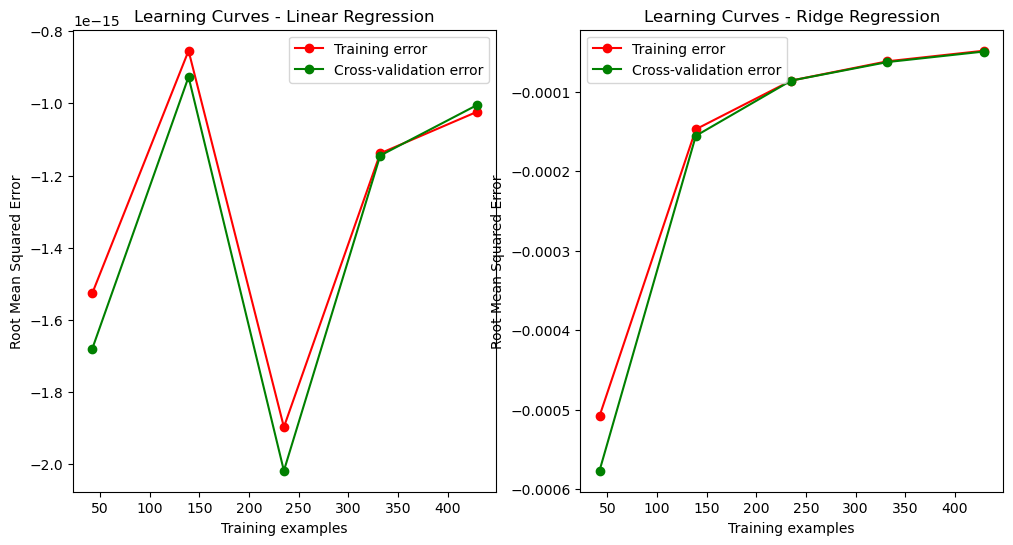

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
linear_regression = LinearRegression()
ridge_regression = Ridge().set_params(**param_results['Ridge_fs'])
plot_learning_curves(linear_regression, X_train, y_train, 'Learning Curves - Linear Regression', axs[0])
plot_learning_curves(ridge_regression, X_train, y_train, 'Learning Curves - Ridge Regression', axs[1])
plt.show()

Here we can indeed see that only the linear regression model is overfitting, the learning curve on the ridge regression model appears to be converging to a plateau, suggesting healthy learning. We will continue to look toward our polynomial regression model, evaluating, and plotting learning.

In [ ]:
best_polynomialregression_fs = trained_models['PolynomialRegression_fs'].set_params(**param_results['PolynomialRegression_fs'])
y_pred = best_polynomialregression_fs.predict(X_test_fs)
rmse = mean_squared_error(y_test_fs, y_pred, squared=False)
print(f"Mean squared error: {rmse}")

Mean squared error: 0.07408518576412122


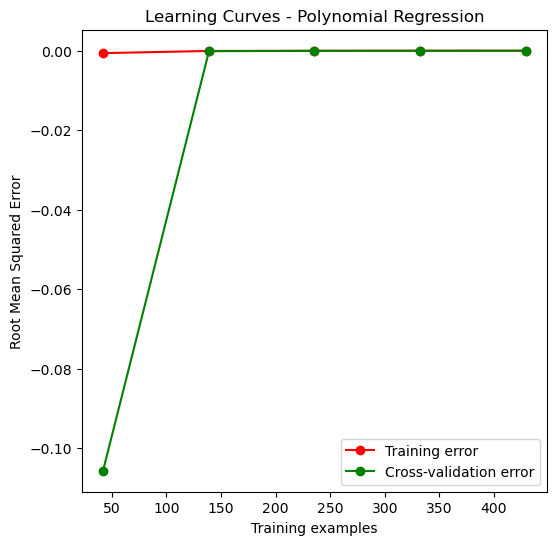

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

polyreg = PolynomialRegression()
polyreg.set_params(**param_results['PolynomialRegression_fs'])
plot_learning_curves(polyreg, X_train_fs, y_train_fs, 'Learning Curves - Polynomial Regression', ax)
plt.show()

### Conclusion

Within our data preprocessing we applied one-hot encoding, and imputed missing values with the mode (typically a strange choice for regression, but after some exploration of the feature correlations comparing against different means of imputation; we did find this to be most effective). We applied a standard scaler to our data, and used a stratified shuffle split to partition our dataset into training and testing sets, we did this to account for the fact the dataset we are using (around 750 samples) is quite small; we stratified based upon the feature 'X5' (Overall Height) as it had the greatest correlation to our target variable - this means the split of our dataset, will be representative of the distribution of 'X5' amongst our dataset, when working with small datasets, this is very important, otherwise we risk introducing bias into our model. A duplicate of our dataset was created for the sake of experimenting with feature selection, which appeared to improve perforance on all models; features with a correlation of less than 0.25 (out of 1.0) to the target variable were dropped, in this case it was the features 'X6', and 'X8' that were ridded of.

Trialling the models: Linear Regression, Polynomial regression with L2 regression (provided by Ridge estimator), Elastic Net, Lasso, and Ridge regression. Grid searches were performed iteratively over all the models, and once again to make use of the 'feature selected' copy of the dataset. All grid searches trialled a plethora of parmeters for each model to find the optimal ones, and once again accounting for the small size of the dataset 5 fold cross validation was implemented to combat overfitting.

At this point we found the two best scoring models (scored within our grid searches by a root mean squared error, we opted in for this metric due to it's versatility regarding regression problems, and as accuracy will be most ledgable here in garnering an understanding for how many units off our predictions are to the 'Heating Load'). We found here that the best models were ___ and ___ with the parameters ___ for ___ and ___ for ___. Continuing on, the same models were reinstantiated, with the 'best' parmaeters found within the grid search, evaluated on the same metric (RMSE), these scores appeared suspiciously low, so the learning curves were plotted to see if overfitting was occuring. From this we found ___.

